In [2]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists

import torch
from torch.nn import CrossEntropyLoss
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torchinfo import summary

from util import test_loss_Unet, train_U_NET, plot_loss, plot_acc, inference_time

plt.rcParams['figure.dpi'] = 100

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [4]:
batch_size = 4
image_size = (256, 256)

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.CenterCrop(image_size)])

target_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(0.007843137718737125, 0.003921568393707275),transforms.CenterCrop(image_size), 
    transforms.Normalize(-1, 1)])

train_dataset = torchvision.datasets.OxfordIIITPet(root='./data/OxfordIIITPet', split="trainval", target_types="segmentation",
                                        download=True, transform=transform, target_transform=target_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.OxfordIIITPet(root='./data/OxfordIIITPet', split="test", target_types="segmentation",
                                        download=True, transform=transform, target_transform=target_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

input_shape = (batch_size, 3, image_size[0], image_size[1])

In [4]:
uniq = []
for img in train_dataset:
    uniq.extend(torch.unique(img[1]).numpy())
    uniq = np.unique(uniq).tolist()
    break
#uniq = np.array(uniq).astype(int)
print(uniq)

[-1.1920928955078125e-07, 1.0, 2.0]


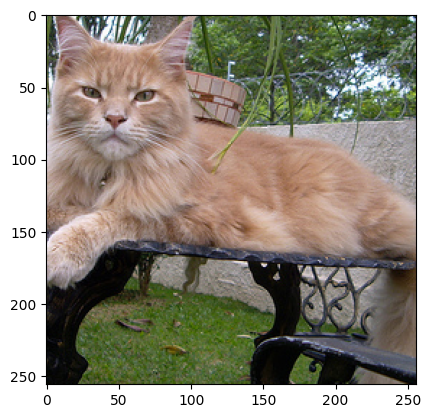

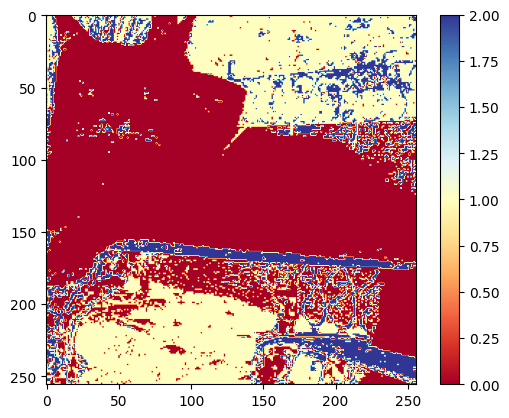

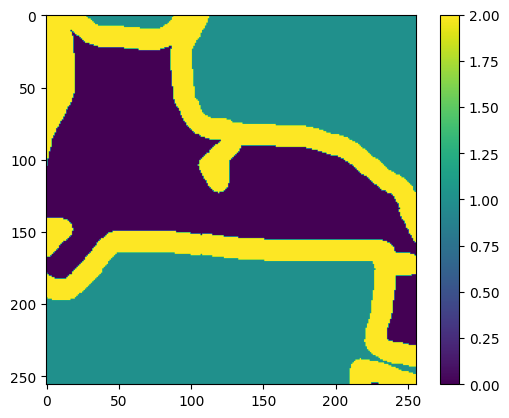

tensor(-1.1921e-07)


In [5]:
#print(train_dataset[2][0].shape)
img = torch.transpose(train_dataset[1000][0], 2,0)
img = torch.transpose(img, 1,0)
plt.imshow(img)
plt.show()

img_max = torch.argmax(train_dataset[1000][0], 0)
#img_max = torch.transpose(img_max, 2,0)
#img_max = torch.argmax(img_max, 2)
plt.imshow(img_max, cmap="RdYlBu")
plt.colorbar()
plt.show()

seg = torch.transpose(train_dataset[1000][1], 2,0)
seg = torch.transpose(seg, 1,0)
plt.imshow(seg)
plt.colorbar()
plt.show()
print(torch.min(seg))

In [4]:
from Models import U_Net

U_NN = U_Net(input_shape, output_channels=3, initial_lr=0.01, momentum=0.9, weight_decay=0)

summary(U_NN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
U_Net                                    [4, 3, 256, 256]          --
├─ModuleDict: 1-1                        --                        --
│    └─Sequential: 2-1                   [4, 64, 256, 256]         --
│    │    └─Conv2d: 3-1                  [4, 64, 256, 256]         1,792
│    │    └─ReLU: 3-2                    [4, 64, 256, 256]         --
│    │    └─BatchNorm2d: 3-3             [4, 64, 256, 256]         128
│    │    └─Conv2d: 3-4                  [4, 64, 256, 256]         36,928
│    │    └─ReLU: 3-5                    [4, 64, 256, 256]         --
│    │    └─BatchNorm2d: 3-6             [4, 64, 256, 256]         128
│    └─MaxPool2d: 2-2                    [4, 64, 128, 128]         --
│    └─Sequential: 2-3                   [4, 128, 128, 128]        --
│    │    └─Conv2d: 3-7                  [4, 128, 128, 128]        73,856
│    │    └─ReLU: 3-8                    [4, 128, 128, 128]        --
│ 

In [5]:
PATH = "./models/U_Net/U_NN.pth"

if exists(PATH):
    U_NN = torch.load(PATH)
    U_NN.eval()

In [6]:
criterion = CrossEntropyLoss()
epochs = 10


train_U_NET(U_NN, criterion=criterion, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
        epochs=epochs, batches_to_test=300, patience=5, device=device, print_test=True, verbose=False, p_randomTransform=0.6)

[1,   300] train_loss: 0.402
test_loss: 0.421, test_accuracy: 83.41848644257631
[1,   600] train_loss: 0.384
test_loss: 0.434, test_accuracy: 82.8586074109622
[1,   900] train_loss: 0.379
test_loss: 0.441, test_accuracy: 82.43151893730091
[2,   280] train_loss: 0.394
test_loss: 0.597, test_accuracy: 76.51769513816137
[2,   580] train_loss: 0.380
test_loss: 0.429, test_accuracy: 82.93670795697483
[2,   880] train_loss: 0.363
test_loss: 0.434, test_accuracy: 83.39368602371111
[3,   260] train_loss: 0.381
test_loss: 0.415, test_accuracy: 83.86471473608592
[3,   560] train_loss: 0.374
test_loss: 0.429, test_accuracy: 83.05582299678258
[3,   860] train_loss: 0.365
test_loss: 0.394, test_accuracy: 84.4921824262135
[4,   240] train_loss: 0.363
test_loss: 0.440, test_accuracy: 82.97631301942265
[4,   540] train_loss: 0.353
test_loss: 0.413, test_accuracy: 83.69411199220879
[4,   840] train_loss: 0.345
test_loss: 0.468, test_accuracy: 81.9787857999721
[5,   220] train_loss: 0.338
test_loss: 0.4

In [7]:
torch.save(U_NN, "./models/U_Net/U_NN.pth")

In [5]:
U_NN = torch.load("./models/U_Net/U_NN.pth")

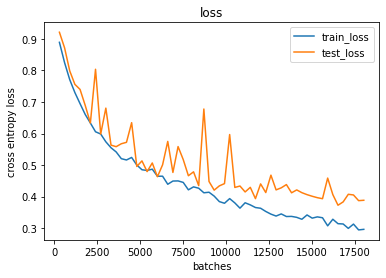

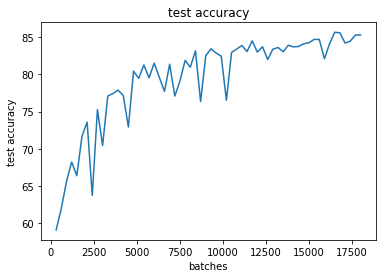

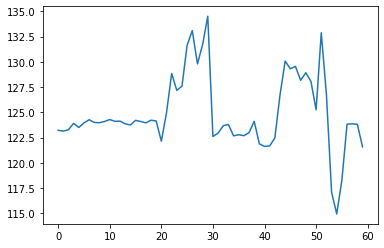

124.90859375


In [9]:
plot_loss(U_NN)
plot_acc(U_NN)

plt.plot(U_NN.train_time)
plt.show()
print(np.mean(U_NN.train_time))

In [10]:
print("Training time (s):")
print(f"mean: {round(np.mean(U_NN.train_time), 3)}")
print(f"std: {round(np.std(U_NN.train_time), 3)}")

Training time (s):
mean: 124.909
std: 3.637


In [11]:
inference_times = inference_time(U_NN, test_dataloader, device)
print("Inference time (ns)")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time (ns)
4.425e+06
7.0e+06


42


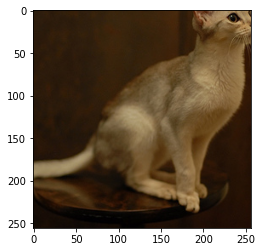

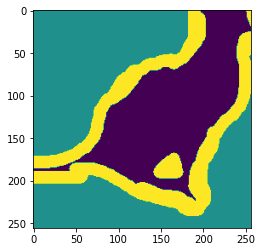

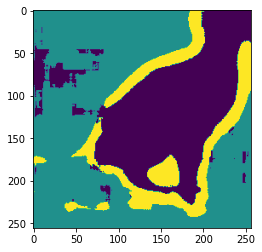

In [10]:
def show_segmentation_results(NN, dataset, index, device):
    img = torch.transpose(dataset[index][0], 2, 0)
    img = torch.transpose(img, 1,0)
    plt.imshow(img)
    plt.show()

    plt.imshow(dataset[index][1][0])
    plt.show()

    seg = dataset[index][0]
    seg = seg[None,:,:,:].to(device)
    outputs = NN(seg)
    outputs = torch.argmax(outputs, 1, keepdim=True)
    plt.imshow(outputs[0][0].detach().to("cpu").numpy())
    plt.show()

ind = int(np.random.rand(1) * 1000)
print(ind)
show_segmentation_results(U_NN, test_dataset, ind, device)